https://www.kaggle.com/c/shopee-sentiment-analysis/overview     

### Background

At Shopee, we always strive to ensure the customer’s highest satisfaction. Whatever product is sold on Shopee, we ensure the best user experience starting from product searching to product delivery, including product packaging, and product quality. Once a product is delivered, we always encourage our customer to rate the product and write their overall experience on the product landing page.

The rating and comments provided for a product by our buyers are most important to us. These product reviews help us to understand our customers needs and quickly adapt our services to provide a much better experience for our customers for the next order. The user's comments for a product ranges from aspects including delivery services, product packaging, product quality, product specifications, payment method, etc. Therefore it is important for us to build an accurate system to understand these reviews which has a great impact on overall Shopee’s user experience. This system is termed: "Shopee Product Review Sentiment Analyser".

### Task

In this competition, a multiple product review sentiment classification model needs to be built. There are ~150k product reviews from different categories, including electronics, furniture, home & living products like air-conditioner and fashion products like T-shirts, rings, etc. For data security purposes, the review ids will be desensitized. The evaluation metrics is top-1 accuracy.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

%matplotlib inline

### Load Data

In [2]:
# Read in training data
data = pd.read_csv('./data/train.csv')

In [3]:
data.head()

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146811 entries, 0 to 146810
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  146811 non-null  int64 
 1   review     146811 non-null  object
 2   rating     146811 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [5]:
# Imbalanced class
data['rating'].value_counts(normalize=True).sort_index()

1    0.100708
2    0.086540
3    0.244811
4    0.285163
5    0.282779
Name: rating, dtype: float64

### Text pre-processing

In [6]:
def stem_text(raw_text):
    
    # Remove HTML tags
    review_text = BeautifulSoup(raw_text).get_text()
    
    # Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    
    # Convert words to lower case and split each word up
    words = letters_only.lower().split()
    
    # Convert stopwords to a set
    stops = set(stopwords.words('english'))
    
    # Adding on stopwords that were frequently occuring across all ratings
    stops.update(['good','product','quality','delivery','delivering'])
    
    # Remove stopwords
    meaningful_words = [w for w in words if w not in stops]
    
    # Instantiate PorterStemmer
    p_stemmer = PorterStemmer()
    
    # Stem words
    meaningful_words = [p_stemmer.stem(w) for w in meaningful_words]
    
    # Join words back into one string
    return(" ".join(meaningful_words))

In [7]:
# Pre-process raw text
data['review_clean'] = data['review'].map(stem_text)

In [8]:
# Let's take a look at a random raw text
data.loc[100]['review']

'Very misleading label on the product. It says case for Iphone 6 6s plus but they only have 6s plus by the way. Lol fix your labeling so everybody can understand it because it’s the first thing that customers read, not the details below it. Plus the seller is not accommodating.\xa0 Wrong item received'

In [9]:
# This is the pre-processed version
data.loc[100]['review_clean']

'mislead label say case iphon plu plu way lol fix label everybodi understand first thing custom read detail plu seller accommod wrong item receiv'

In [10]:
# Find the number of meaningful words in each review
data['review_clean_len'] = data['review_clean'].str.split().map(len)

In [11]:
# Let's take a look at the reviews that have 0 meaningful words. These reviews consist mostly of emojis
data[data['review_clean_len']==0].head(20)

,review_id,review,rating,review_clean,review_clean_len
26,26,The product quality is not good,1,,0
48,48,The product quality is not good,1,,0
114,114,The product quality is not good.,1,,0
387,387,The product quality is not good,1,,0
412,412,The product quality is not good. The product ...,1,,0
431,431,The product quality is not good,1,,0
500,500,The product quality is not good.,1,,0
607,607,The product quality is not good.,1,,0
624,624,The product quality is not good,1,,0
752,752,The product quality is not good,1,,0


In [12]:
# Too much noise. Let's drop these reviews that do not have any meaningful words
data = data.drop(data[data['review_clean_len']==0].index)

In [13]:
# Reindex the dataframe
data.reset_index(drop=True, inplace=True)

### EDA

In [14]:
data.columns

Index(['review_id', 'review', 'rating', 'review_clean', 'review_clean_len'], dtype='object')

In [15]:
# Average length of each review by rating is roughly the same
data.groupby('rating')['review_clean_len'].mean()

rating
1    10.509685
2     8.721274
3     8.231493
4     8.123828
5     8.081626
Name: review_clean_len, dtype: float64

In [39]:
def barplot_cvec(rating, titles, color, xlimit):
    
    words_series = data[data['rating']==rating]['review_clean']
    
    fig, ax = plt.subplots(1, 2, figsize=(25,12))
    
    ngram = [(1,1),(2,2)] # The ngrams that we would like to plot
    
    for i in range(2):
            
        # Use CountVectorizer to tokenize the text, 
        cvec = CountVectorizer(stop_words='english', ngram_range=ngram[i])

        # Save the tokens in a dataframe
        cvec_df = pd.DataFrame(cvec.fit_transform(words_series).todense(), columns=cvec.get_feature_names())
        sum_words = cvec_df.sum(axis=0) # Sum up the no. of occurences for each word
        top_words = sum_words.sort_values(ascending=False).head(20)
        top_words.sort_values(ascending=True).plot(kind='barh', color=color, ax=ax[i])

        # Adjust plot aesthetics
        ax[i].set_title(titles[i], size=25, weight='bold')
        ax[i].set_xlabel('Count', size=20)
        ax[i].set_xlim(xlimit) # Setting a limit so that the barplots are comparable
        ax[i].tick_params(axis='both', which='major', labelsize=20)
        ax[i].tick_params(axis='both', which='minor', labelsize=20)

    plt.tight_layout()

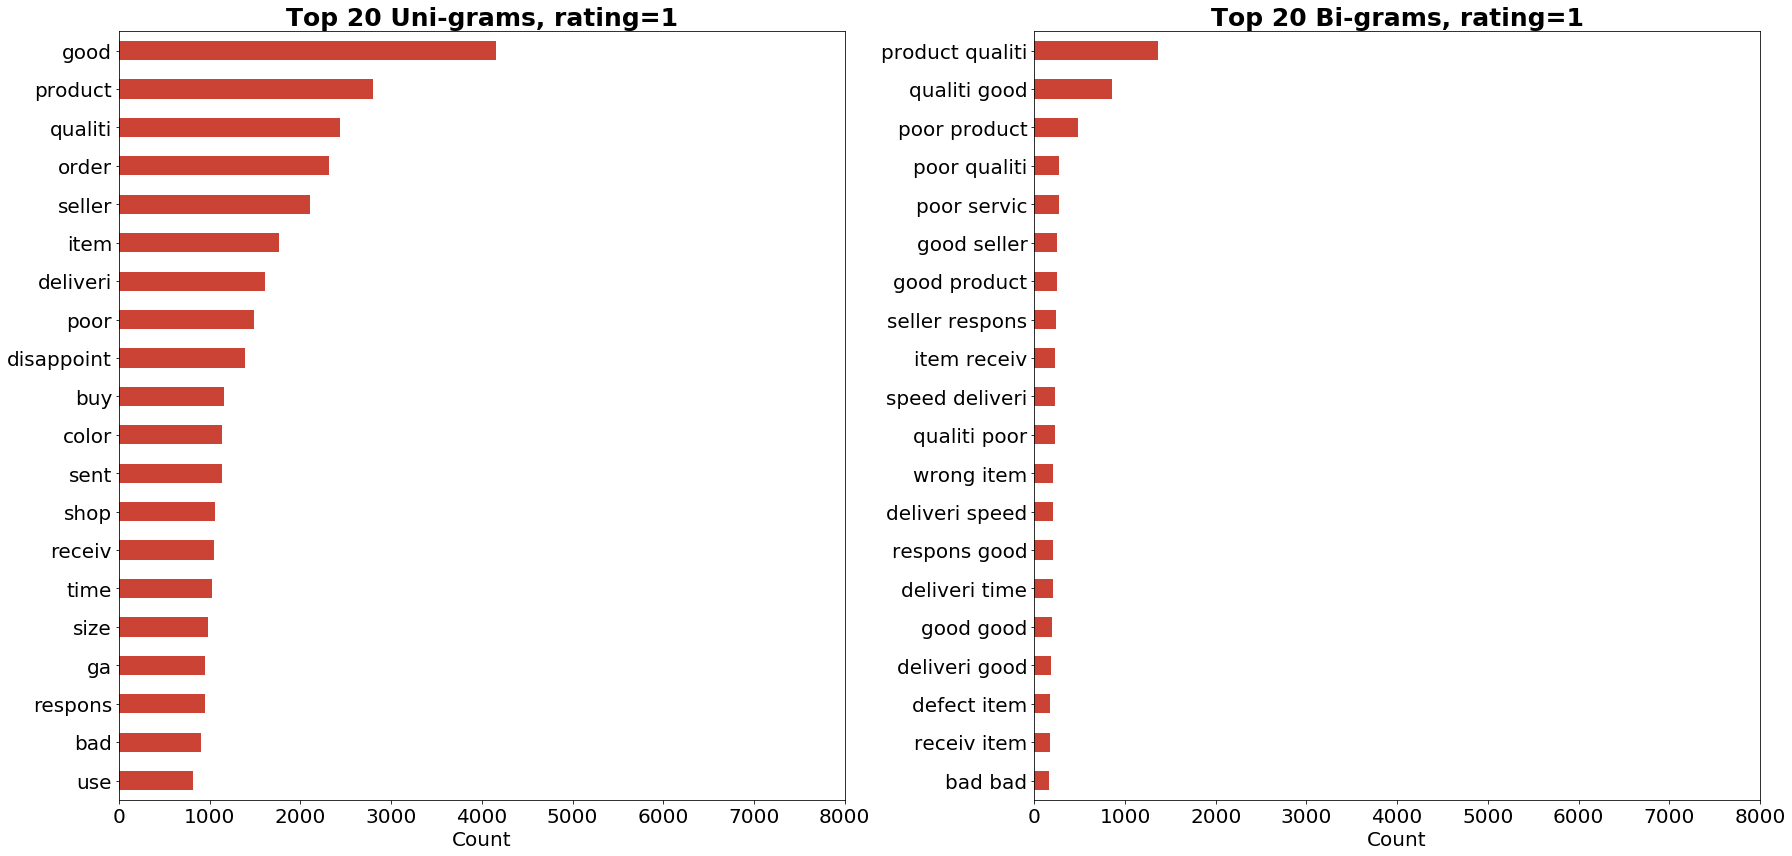

In [47]:
barplot_cvec(rating=1, 
             titles=['Top 20 Uni-grams, rating=1', 'Top 20 Bi-grams, rating=1'],
             color='#CB4335',
             xlimit=(0,8000))

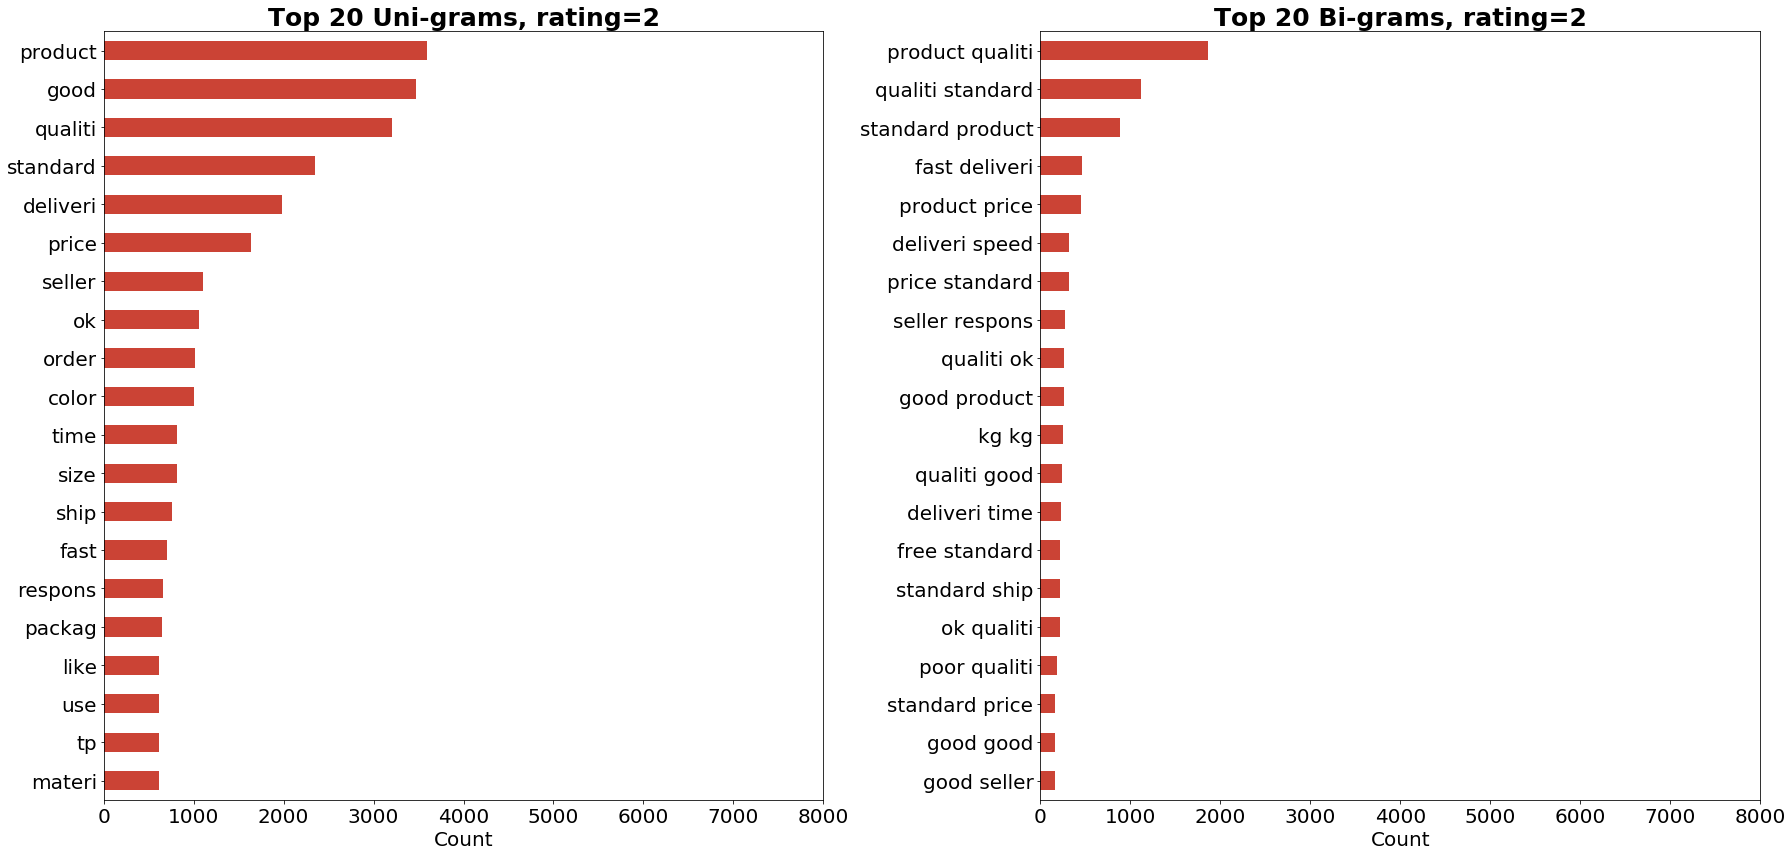

In [48]:
barplot_cvec(rating=2, 
             titles=['Top 20 Uni-grams, rating=2', 'Top 20 Bi-grams, rating=2'],
             color='#CB4335',
             xlimit=(0,8000))

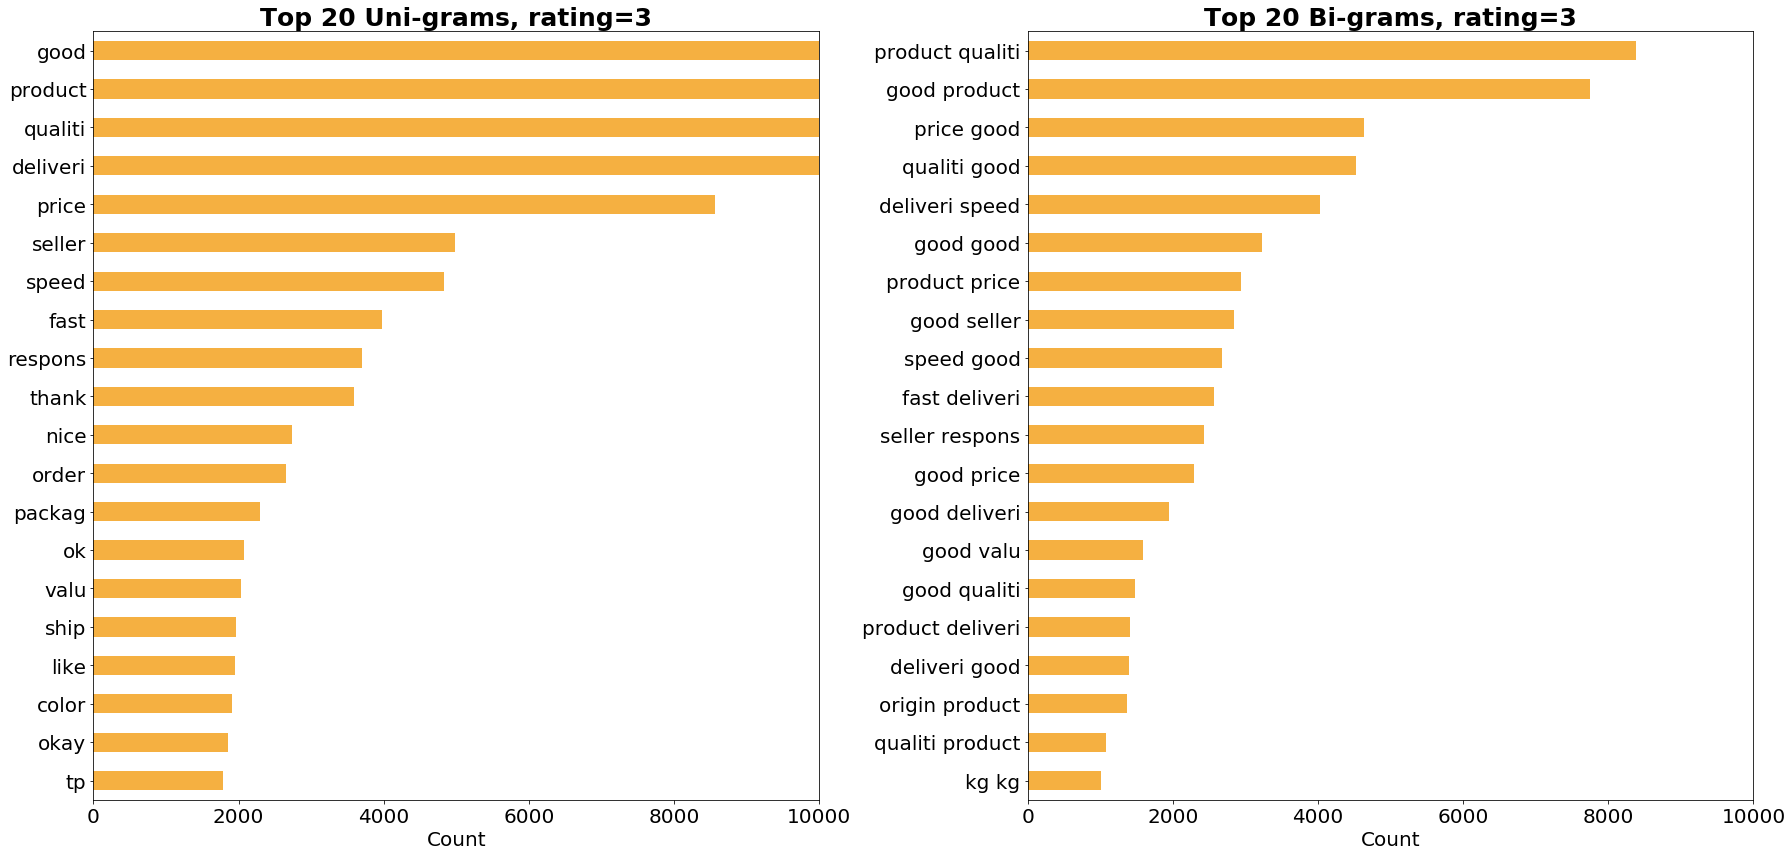

In [50]:
barplot_cvec(rating=3, 
             titles=['Top 20 Uni-grams, rating=3', 'Top 20 Bi-grams, rating=3'],
             color='#F5B041',
             xlimit=(0,10000))

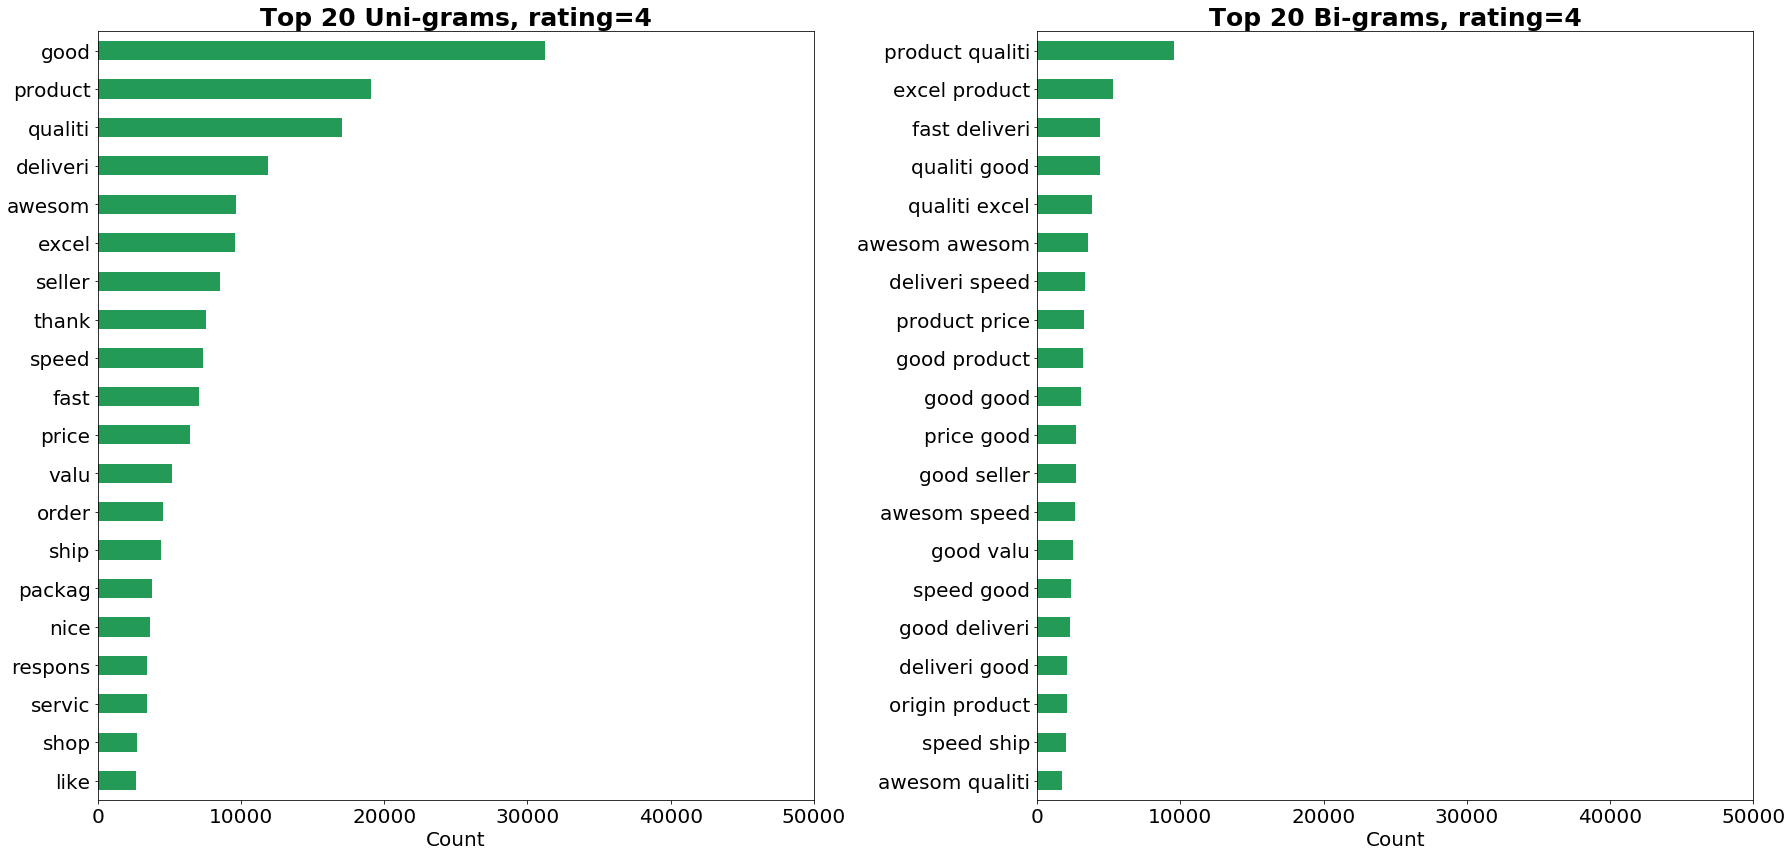

In [55]:
barplot_cvec(rating=4, 
             titles=['Top 20 Uni-grams, rating=4', 'Top 20 Bi-grams, rating=4'],
             color='#239B56',
             xlimit=(0,50000))

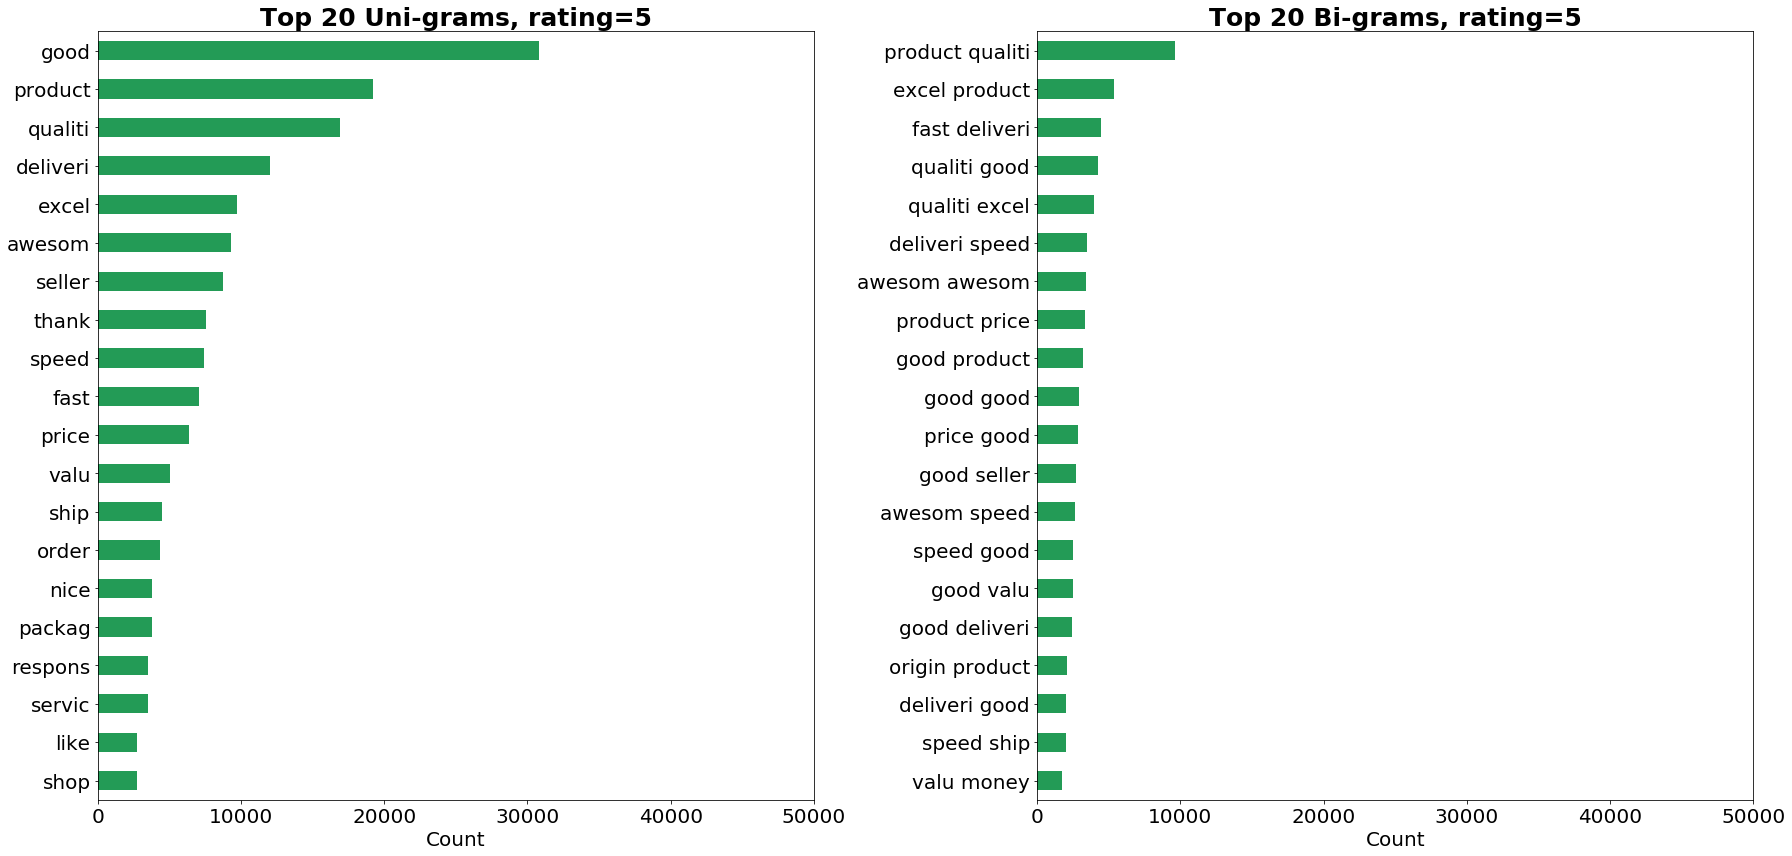

In [54]:
barplot_cvec(rating=5, 
             titles=['Top 20 Uni-grams, rating=5', 'Top 20 Bi-grams, rating=5'],
             color='#239B56',
             xlimit=(0,50000))

### Modelling

In [16]:
X = data['review_clean']
y = data['rating']

In [17]:
# Create a train and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
X_train.shape

(115244,)

In [19]:
X_val.shape

(28812,)

In [20]:
y_train.shape

(115244,)

In [21]:
y_val.shape

(28812,)

In [22]:
y_train.value_counts(normalize=True).sort_index()

1    0.100699
2    0.087840
3    0.239119
4    0.287364
5    0.284978
Name: rating, dtype: float64

In [23]:
y_val.value_counts(normalize=True).sort_index()

1    0.100722
2    0.087845
3    0.239102
4    0.287346
5    0.284985
Name: rating, dtype: float64

In [24]:
# Use count vectorizer to check how many unique words there are
cvec = CountVectorizer(stop_words='english') 
cvec_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), columns=cvec.get_feature_names())
cvec_df.shape

(115244, 42866)

### TF-IDF & Logistic Regression

In [81]:
# Create a pipeline with TF-IDF and Logistic Regression
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(random_state=42, max_iter=10000))
])

# Search over the following values of hyperparameters:
pipe_tvec_lr_params = {
    'tvec__max_features': [10000], 
    'tvec__min_df': [5], #2,3 
    'tvec__max_df': [.9], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
    'lr__penalty': ['l2'],
    'lr__C': [1] #.1
}

# Instantiate GridSearchCV
gs_tvec_lr = GridSearchCV(pipe_tvec_lr, # Objects to optimise
                          param_grid = pipe_tvec_lr_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_lr.fit(X_train, y_train)

# Generate predictions on validation set
tvec_lr_pred = gs_tvec_lr.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_lr.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_lr.best_score_)
print('Training score:', gs_tvec_lr.score(X_train, y_train))
print('Validation score:', gs_tvec_lr.score(X_val, y_val))
print('')

Best parameters:  {'lr__C': 1, 'lr__penalty': 'l2', 'tvec__max_df': 0.9, 'tvec__max_features': 10000, 'tvec__min_df': 5}
Best CV score:  0.4550745145581307
Training score: 0.5313093787544414
Validation score: 0.4594594594594595

Classification report for validation set
              precision    recall  f1-score   support

           1       0.57      0.61      0.59      2955
           2       0.50      0.24      0.32      2540
           3       0.49      0.61      0.54      7183
           4       0.41      0.40      0.41      8365
           5       0.42      0.40      0.41      8298

    accuracy                           0.46     29341
   macro avg       0.48      0.45      0.45     29341
weighted avg       0.46      0.46      0.45     29341




ValueError: Shape of passed values is (5, 5), indices imply (2, 2)

### TF-IDF & SVC

In [ ]:
# Create a pipeline with TF-IDF Vectorizer and SVC
pipe_tvec_svc = Pipeline([
    ('tvec', TfidfVectorizer(stop_words='english')),
    ('svc', SVC()) 
])

# Search over the following values of hyperparameters:
pipe_tvec_svc_params = {
    'tvec__max_features': [1000], #200,500
    'tvec__min_df': [5], 
    'tvec__max_df': [.9], 
#     'tvec__ngram_range':[(1,1),(1,2)],  
    'svc__kernel': ['linear'], #'poly', 'rbf'
#     'svc__degree': [3],
    'svc__C': [.1] # .01
}

# Instantiate GridSearchCV
gs_tvec_svc = GridSearchCV(pipe_tvec_svc, # Objects to optimise
                          param_grid = pipe_tvec_svc_params, # Hyperparameters for tuning
                          cv=10) # 10-fold cross validation

# Fit model on to training data
gs_tvec_svc.fit(X_train, y_train)

# Generate predictions on validation set
tvec_svc_pred = gs_tvec_svc.predict(X_val)

# Print best parameters
print('Best parameters: ', gs_tvec_svc.best_params_)

# Print accuracy scores
print('Best CV score: ', gs_tvec_svc.best_score_)
print('Training score:', gs_tvec_svc.score(X_train, y_train))
print('Validation score:', gs_tvec_svc.score(X_val, y_val))
print('')

### Score Model on Kaggle

In [91]:
test = pd.read_csv('./data/test.csv')

In [92]:
# Pre-process text
test['review_clean'] = test['review'].map(stem_text)

In [93]:
test.head()

,review_id,review,review_clean
0,1,"Great danger, cool, motif and cantik2 jg model...",great danger cool motif cantik jg model cepet ...
1,2,One of the shades don't fit well,one shade fit well
2,3,Very comfortable,comfort
3,4,Fast delivery. Product expiry is on Dec 2022. ...,fast expiri dec wrap properli damag item
4,5,it's sooooo cute! i like playing with the glit...,sooooo cute like play glitter better brows pho...


In [95]:
# Generate predictions
test['rating'] = gs_tvec_lr.predict(test['review_clean'])

In [96]:
test.head()

,review_id,review,review_clean,rating
0,1,"Great danger, cool, motif and cantik2 jg model...",great danger cool motif cantik jg model cepet ...,3
1,2,One of the shades don't fit well,one shade fit well,4
2,3,Very comfortable,comfort,5
3,4,Fast delivery. Product expiry is on Dec 2022. ...,fast expiri dec wrap properli damag item,4
4,5,it's sooooo cute! i like playing with the glit...,sooooo cute like play glitter better brows pho...,4


In [97]:
test.drop(['review','review_clean'], axis=1, inplace=True)

In [98]:
test.head()

,review_id,rating
0,1,3
1,2,4
2,3,5
3,4,4
4,5,4


In [99]:
# Save predictions to a submissions file
test.to_csv('submissions.csv', index=False)